<a href="https://colab.research.google.com/github/ttezy/Time-Sequence-Analysis/blob/main/LSTM_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Load data**
## **You may need to upload pollution.csv to /content/pollution.csv**

## **Import libs**

In [ ]:
from matplotlib import pyplot as plt

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from numpy import concatenate
from math import sqrt

## **Load dataset**

In [ ]:
df=pd.read_csv('pollution.csv',header=0, index_col=0)
df

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


## **Visualize data**

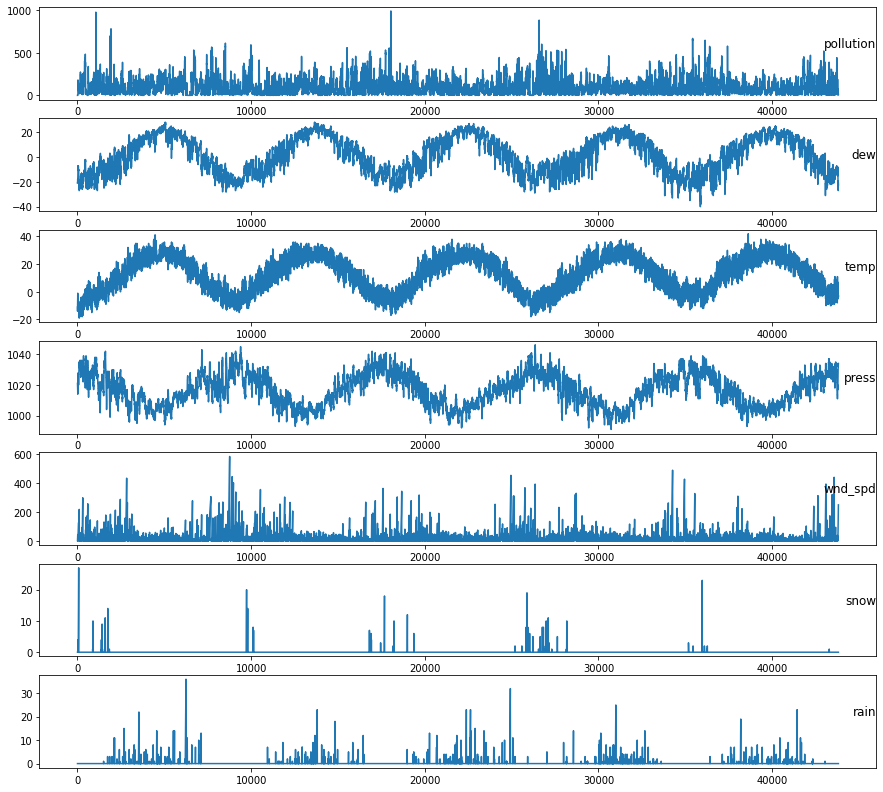

In [ ]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize = (15, 14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# **Step 2: Prepare for. model**

## **Encode wind direction**

In [ ]:
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')

df['wnd_dir'] = values[:, 4]

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,1.0,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,1.0,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,1.0,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,1.0,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,1.0,12.97,0,0


## **Normalize data values between 0 and 1**

In [ ]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(scaled)

[[0.         0.2794118  0.13114753 ... 0.00229001 0.         0.        ]
 [0.         0.2794118  0.1147541  ... 0.00763907 0.         0.        ]
 [0.         0.2794118  0.13114753 ... 0.01069811 0.         0.        ]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.41399646 0.         0.        ]
 [0.00804829 0.2647059  0.24590163 ... 0.4208665  0.         0.        ]
 [0.01207243 0.2794118  0.26229507 ... 0.42621556 0.         0.        ]]


## **Reframe dataset for supervised learning**

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)  var1(t)
1        0.0   0.279412   0.131148  ...        0.0        0.0      0.0
2        0.0   0.279412   0.114754  ...        0.0        0.0      0.0
3        0.0   0.279412   0.131148  ...        0.0        0.0      0.0
4        0.0   0.279412   0.081967  ...        0.0        0.0      0.0
5        0.0   0.294118   0.114754  ...        0.0        0.0      0.0

[5 rows x 9 columns]


## **Split training and testing data**

In [ ]:
# split into train and test sets
values = reframed.values

# use first 90% data to train
# n_train_hours = 365 * 24
n_train_hours = int(len(values) * 0.9)
train = values[:n_train_hours]
test = values[n_train_hours:]

# split into input and output (var(t-1), var1(t))
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("train_X shape: ", train_X.shape, " train_y shape: ", train_y.shape,
      "\ntest_X shape: ", test_X.shape, " test_y shape: ", test_y.shape)

train_X shape:  (39440, 1, 8)  train_y shape:  (39440,) 
test_X shape:  (4383, 1, 8)  test_y shape:  (4383,)


# **Step 3: Train LSTM(Long Short-term Memory) model**

## **Design network**

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

## **Fit model**

In [ ]:
epochs = 50 # modify here to choose training epoches
history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)

Epoch 1/50
548/548 - 4s - loss: 0.0335 - val_loss: 0.0265
Epoch 2/50
548/548 - 1s - loss: 0.0153 - val_loss: 0.0132
Epoch 3/50
548/548 - 1s - loss: 0.0140 - val_loss: 0.0122
Epoch 4/50
548/548 - 1s - loss: 0.0139 - val_loss: 0.0120
Epoch 5/50
548/548 - 1s - loss: 0.0139 - val_loss: 0.0118
Epoch 6/50
548/548 - 1s - loss: 0.0139 - val_loss: 0.0118
Epoch 7/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 8/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 9/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 10/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 11/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 12/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0118
Epoch 13/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0117
Epoch 14/50
548/548 - 1s - loss: 0.0137 - val_loss: 0.0118
Epoch 15/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0119
Epoch 16/50
548/548 - 1s - loss: 0.0138 - val_loss: 0.0119
Epoch 17/50
548/548 - 1s - loss: 0.0137 - val_loss: 0.0119
Epoch 

## **Show the training loss and test loss**

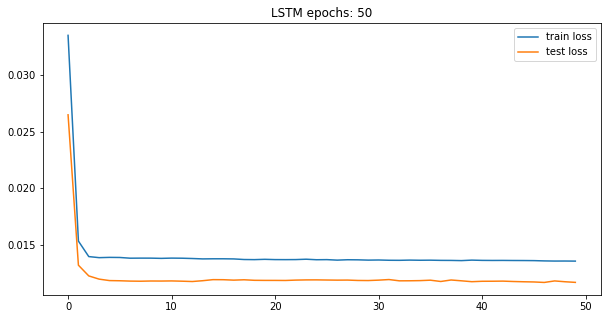

In [ ]:
# plot history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

# **Step 4: Implement Data Forecasting**

Test RMSE: 21.961


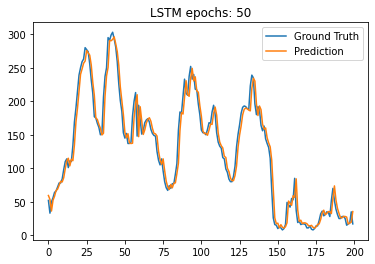

In [ ]:
futureStep = 1
yhat = model.predict(test_X, steps=futureStep)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

plt.plot(inv_y[:200], label='Ground Truth')
plt.plot(inv_yhat[:200], label='Prediction')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()